# Medical Insurance Cost Prediction

## Importing and Loading Dataset



Dataset: insurance.csv  
Target Variable: charges  
Type: Mixed Feature Regression  

Aim is to predict medical insurance charges using regression techniques while handling categorical variables and evaluating model performance using R² and residual diagnostics.

### Import Libraries

We import libraries required for:

- Data manipulation
- Visualization
- Encoding
- Regression models
- Diagnostics
- Evaluation metrics

In [5]:
import urllib.request

url = "https://raw.githubusercontent.com/stedy/Machine-Learning-with-R-datasets/master/insurance.csv"
urllib.request.urlretrieve(url, "insurance.csv")

print("Dataset downloaded successfully!")

Dataset downloaded successfully!


In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import TargetEncoder
import statsmodels.api as sm

import warnings
warnings.filterwarnings("ignore")

In [6]:
import pandas as pd

df = pd.read_csv("insurance.csv")
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


### Exploratory Data Analysis

We perform:

• Histograms  
• Boxplots by category  
• Correlation analysis  

This helps understand:

- Distribution of charges
- Effect of smoking, region, sex
- Linear relationships

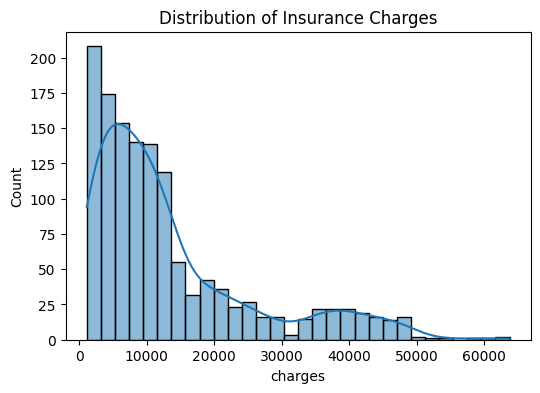

In [8]:
plt.figure(figsize=(6,4))
sns.histplot(df["charges"], kde=True)
plt.title("Distribution of Insurance Charges")
plt.show()

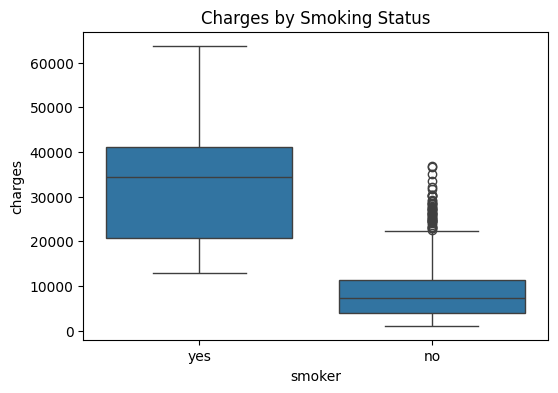

In [9]:
plt.figure(figsize=(6,4))
sns.boxplot(x="smoker", y="charges", data=df)
plt.title("Charges by Smoking Status")
plt.show()

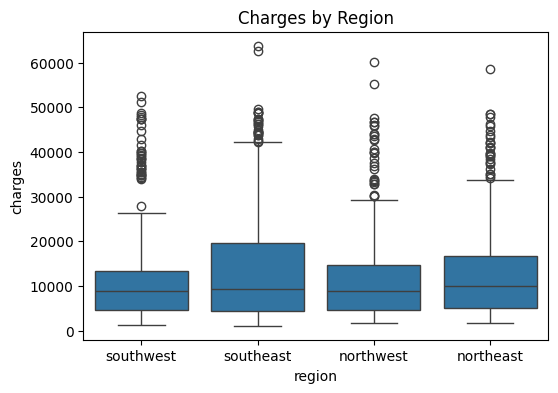

In [10]:
plt.figure(figsize=(6,4))
sns.boxplot(x="region", y="charges", data=df)
plt.title("Charges by Region")
plt.show()

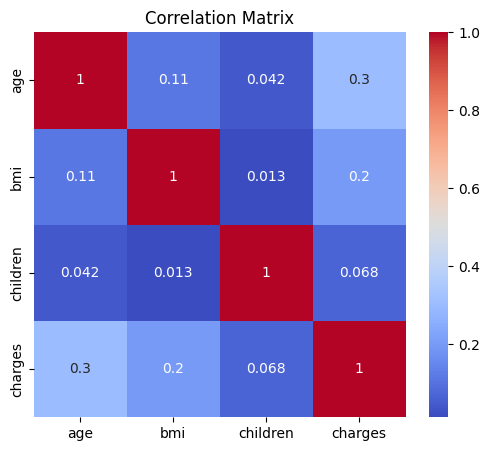

In [11]:
numeric_df = df.select_dtypes(include=['number'])

plt.figure(figsize=(6,5))
sns.heatmap(numeric_df.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

### Encoding Categorical Variables

Dataset contains categorical features:

• sex  
• smoker  
• region  

We compare:

1️. One-Hot Encoding  
2️. Target Encoding  

To evaluate performance differences.

In [12]:
X = df.drop("charges", axis=1)
y = df["charges"]

categorical_cols = ["sex", "smoker", "region"]
numeric_cols = ["age", "bmi", "children"]

### Influential Points Detection using Cook’s Distance

Cook’s Distance measures influence of individual observations.

Formula:

D_i = (Residual² / (p × MSE)) × (h_ii / (1 − h_ii)²)

Observations with:

D_i > 4/n

are considered influential.

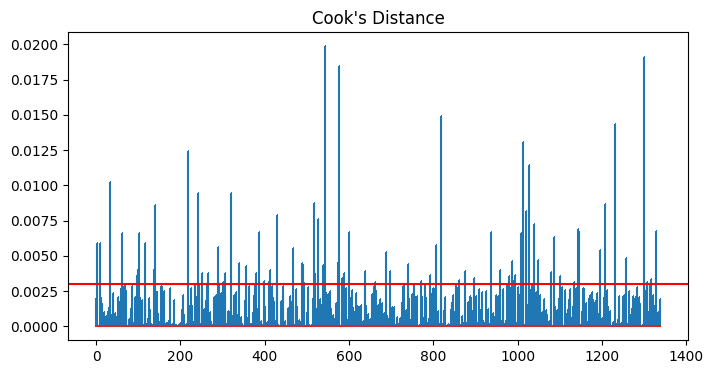

Number of influential points: 87


In [14]:
# One-hot encode 
df_encoded = pd.get_dummies(df, drop_first=True)
df_encoded = df_encoded.astype(float)

# Separate features and target
X_sm = df_encoded.drop("charges", axis=1)
y_sm = df_encoded["charges"]

X_sm = sm.add_constant(X_sm)
model = sm.OLS(y_sm, X_sm).fit()
influence = model.get_influence()
cooks_d = influence.cooks_distance[0]

threshold = 4 / len(df)

plt.figure(figsize=(8,4))
plt.stem(cooks_d, markerfmt=",")
plt.axhline(threshold, color='red')
plt.title("Cook's Distance")
plt.show()

print("Number of influential points:",
      np.sum(cooks_d > threshold))

#### Linear Regression (One-Hot Encoding)

In [15]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_cols),
        ("cat", OneHotEncoder(drop="first"), categorical_cols)
    ]
)

linear_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("model", LinearRegression())
])

linear_pipeline.fit(X, y)

y_pred_lin = linear_pipeline.predict(X)

r2_lin = r2_score(y, y_pred_lin)
mse_lin = mean_squared_error(y, y_pred_lin)

r2_lin, mse_lin

(0.7509130345985207, 36501893.00741544)

#### Polynomial Regression (Degree 2)

Captures nonlinear relationships.

In [16]:
poly_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("poly", PolynomialFeatures(degree=2, include_bias=False)),
    ("model", LinearRegression())
])

poly_pipeline.fit(X, y)

y_pred_poly = poly_pipeline.predict(X)

r2_poly = r2_score(y, y_pred_poly)
mse_poly = mean_squared_error(y, y_pred_poly)

r2_poly, mse_poly

(0.8477668880499397, 22308661.377083823)

#### Lasso Regression

Adds L1 penalty:

Loss = MSE + α Σ |w|

Performs feature selection.

In [17]:
lasso_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("model", Lasso(alpha=0.1))
])

lasso_pipeline.fit(X, y)

y_pred_lasso = lasso_pipeline.predict(X)

r2_lasso = r2_score(y, y_pred_lasso)
mse_lasso = mean_squared_error(y, y_pred_lasso)

r2_lasso, mse_lasso

(0.7509130300047799, 36501893.680594906)

### Evaluation Metric: R²

R² = 1 − (SS_res / SS_tot)

Higher R² indicates better explanatory power.

In [20]:
comparison = pd.DataFrame({
    "Model": ["Linear", "Polynomial", "Lasso"],
    "R2 Score": [r2_lin, r2_poly, r2_lasso],
    "MSE": [mse_lin, mse_poly, mse_lasso],
    "RMSE": [np.sqrt(mse_lin), np.sqrt(mse_poly), np.sqrt(mse_lasso)]
})

comparison

,Model,R2 Score,MSE,RMSE
0,Linear,0.750913,3.650189e+07,6041.679651
1,Polynomial,0.847767,2.230866e+07,4723.204567
2,Lasso,0.750913,3.650189e+07,6041.679707


### Residual Diagnostics

We check:

• Residual distribution  
• Homoscedasticity  
• Normality  

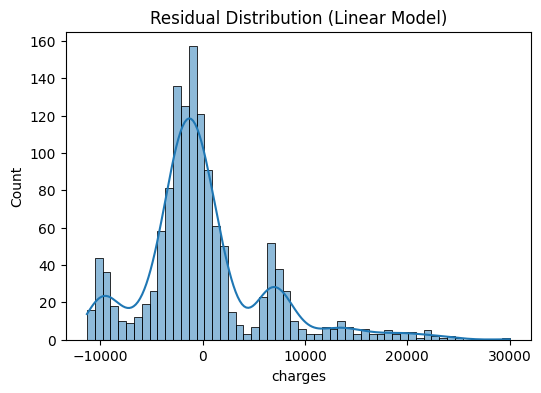

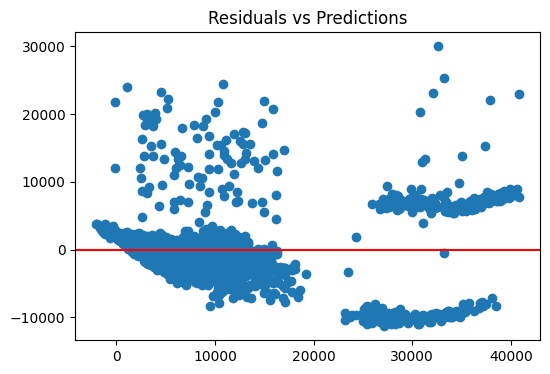

In [21]:
residuals = y - y_pred_lin

plt.figure(figsize=(6,4))
sns.histplot(residuals, kde=True)
plt.title("Residual Distribution (Linear Model)")
plt.show()

plt.figure(figsize=(6,4))
plt.scatter(y_pred_lin, residuals)
plt.axhline(0, color='red')
plt.title("Residuals vs Predictions")
plt.show()

### Final Optimized Pipeline

Recommended:

Data  
→ One-Hot Encoding  
→ Scaling  
→ Polynomial Features (if improves R²)  
→ Lasso Regression  

Justification:

- Handles categorical variables
- Captures nonlinearities
- Controls overfitting
- Removes irrelevant features